In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=FutureWarning)

# ETL

In [33]:
df = pd.read_csv('fraude_bacario.csv')

In [34]:
#df.to_parquet("D:/bootcamp_experience/Bootcamp-machineLearning/fraude_bacario.parquet")

In [35]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [37]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [38]:
df.duplicated().sum()

0

Creando una nueva columna type2 conn las iniciales de 'nameOrig' y 'nameDest'

In [39]:
df['type2'] = df['nameOrig'].str[0] + df['nameDest'].str[0]
columna = df['type2']
del df['type2']
df.insert(2,'type2', columna) # se mueve la columna a la posicion 2 para tener mas orden
df.head()

,step,type,type2,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,CM,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,CM,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,CC,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,CC,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,CM,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Se eliminan columnas innecesarias

In [40]:
df.drop(columns=['nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'], inplace=True)

### Se verifica cuantos tipos de type y type2 hay

In [41]:
df['type'].value_counts().size

5

In [42]:
df['type2'].value_counts().size

2

In [43]:
df.head(3)

,step,type,type2,amount,isFraud
0,1,PAYMENT,CM,9839.64,0
1,1,PAYMENT,CM,1864.28,0
2,1,TRANSFER,CC,181.00,1


### Se convierte las columnas type y type2 en formato numerico, se van preparando los datos para el modelo de Machine Learning

In [44]:
df = pd.get_dummies(df, columns=['type', 'type2'],  dtype=int)

In [45]:
df.head()

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0
3,1,181.00,1,0,1,0,0,0,1,0
4,1,11668.14,0,0,0,0,1,0,0,1


In [46]:
df.duplicated().sum()

7597

In [47]:
df.drop_duplicates(inplace=True)

# EDA
Se realiza un boxplot de las columnas: 'isFraud', 'amount', 'step'

In [48]:
# fig, axs = plt.subplots(1, 3, figsize= (15, 5))
# fig.suptitle('Boxplots', fontsize=20, y=1.05)
# sns.boxplot (x= 'isFraud', data = df, ax=axs[0]).set_title('Fraude', fontsize=12, y=1.02)
# sns.boxplot (x= 'amount', data = df, ax=axs[1]).set_title('Monto', fontsize=12, y=1.02)
# sns.boxplot (x= 'step', data = df, ax=axs[2]).set_title('Hora del mes', fontsize=12, y=1.02);


### Se crea una matriz de correlación

### Se verifica si esta balanceada la etiqueta objetivo

In [49]:
distribucion_isFraud = df['isFraud'].value_counts()
distribucion_isFraud

isFraud
0    6346920
1       8103
Name: count, dtype: int64

In [50]:
f'{round((8213/6354407)*100, 2)} %'

'0.13 %'

Como se observa solo el 0.13% de los datos de la etiqueta objetivo pertenecen a la categoria fraude, por lo tannto es necesario balancear los datos

Ahora observamos el desbalnaceo graficamente

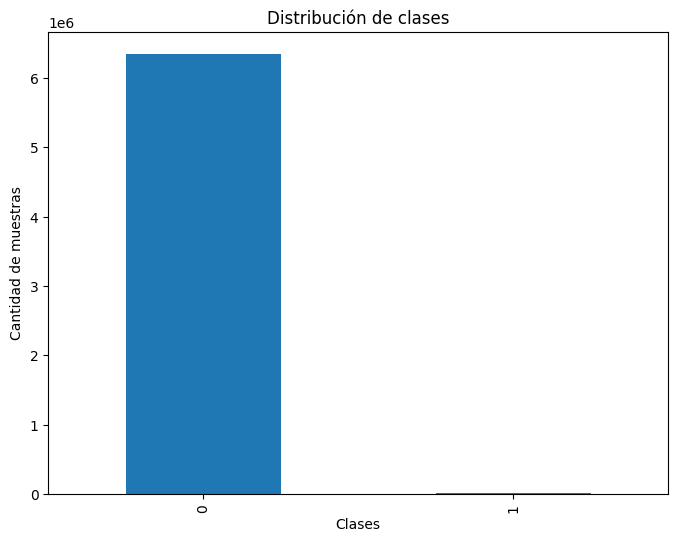

In [51]:
plt.figure(figsize=(8, 6))
distribucion_isFraud.plot(kind='bar')
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Cantidad de muestras');

### Balanceando la etiqueta objetivo

In [52]:
# se toma una muestra de 4.5M
df1 = df[df['isFraud']==1]
df1 = pd.concat([df1, df[df['isFraud']==0].sample(4500000)])
df1.shape

(4508103, 10)

In [53]:
df1.duplicated().sum()

0

Se hace un oversampling de la clase minoritaria

Antes de SMOTE: 4500000 clase mayoritaria,  8103 clase minoritaria
Después de SMOTE: 4500000 clase mayoritaria,  3600000 clase minoritaria
Cantidad de duplicados: 777749


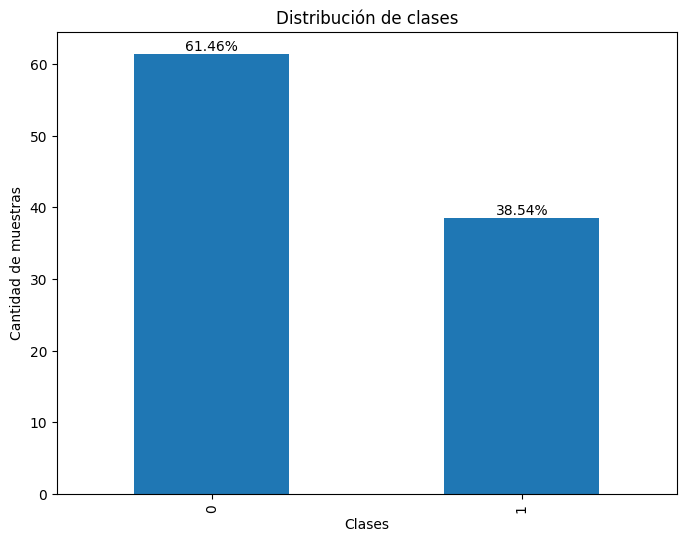

In [88]:
from imblearn.over_sampling import SMOTE
def balanceo_clases(df, porcetaje_resampleo):

    # Instancia SMOTE
    X = df1.drop(columns= 'isFraud')
    y = df1['isFraud']
    smote = SMOTE(sampling_strategy=porcetaje_resampleo, random_state=42)

    # Aplica SMOTE al conjunto de datos
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Verifica el nuevo balance de clases
    print("Antes de SMOTE:", sum(y == 0), "clase mayoritaria, ", sum(y == 1), "clase minoritaria")
    print("Después de SMOTE:", sum(y_resampled == 0), "clase mayoritaria, ", sum(y_resampled == 1), "clase minoritaria")
    df_balanceado = pd.DataFrame(X_resampled, columns=X.columns)
    df_balanceado['isFraud'] = y_resampled
    
    # se verifican cuatos duplicados hay y se borran
    print(f'Cantidad de duplicados: {df_balanceado.duplicated().sum()}')
    
    # y se borran
    df_balanceado.drop_duplicates(inplace=True)
    
    #datos para graficar
    distribucion_isFraud = df_balanceado['isFraud'].value_counts()
    distribucion_isFraud
    
    #grafico
    plt.figure(figsize=(8, 6))
    distribucion_isFraud = df_balanceado['isFraud'].value_counts(normalize=True)*100
    ax = distribucion_isFraud.plot(kind='bar')
    for i in ax.patches:
        ax.text(i.get_x() + i.get_width()/2, i.get_height() + 0.5,
            f'{round(i.get_height(), 2)}%', ha='center')
    plt.title('Distribución de clases')
    plt.xlabel('Clases')
    plt.ylabel('Cantidad de muestras');
    return df_balanceado
df_balanceado = balanceo_clases(df1, 0.8)

In [89]:
df_balanceado.shape

(7322251, 10)

In [91]:
df_balanceado.head(5)

,step,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,isFraud
0,1,181.0,0,0,0,0,1,1,0,1
1,1,181.0,0,1,0,0,0,1,0,1
2,1,2806.0,0,0,0,0,1,1,0,1
3,1,2806.0,0,1,0,0,0,1,0,1
4,1,20128.0,0,0,0,0,1,1,0,1


Se realiza la matriz de correlación

In [92]:
matriz_correlacion = df_balanceado.corr()
matriz_correlacion

,step,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,isFraud
step,1.000000,0.128352,-0.105480,-0.044928,-0.015588,-0.136461,0.083734,0.136461,-0.136461,0.345592
amount,0.128352,1.000000,-0.117639,-0.040790,-0.026859,-0.213709,0.164870,0.213709,-0.213709,0.370777
type_CASH_IN,-0.105480,-0.117639,1.000000,-0.267425,-0.025149,-0.202919,-0.164755,0.202919,-0.202919,-0.313464
type_CASH_OUT,-0.044928,-0.040790,-0.267425,1.000000,-0.042927,-0.346364,-0.281221,0.346364,-0.346364,-0.104132
type_DEBIT,-0.015588,-0.026859,-0.025149,-0.042927,1.000000,-0.032573,-0.026447,0.032573,-0.032573,-0.050318
type_PAYMENT,-0.136461,-0.213709,-0.202919,-0.346364,-0.032573,1.000000,-0.213388,-1.000000,1.000000,-0.405993
type_TRANSFER,0.083734,0.164870,-0.164755,-0.281221,-0.026447,-0.213388,1.000000,0.213388,-0.213388,0.231072
type2_CC,0.136461,0.213709,0.202919,0.346364,0.032573,-1.000000,0.213388,1.000000,-1.000000,0.405993
type2_CM,-0.136461,-0.213709,-0.202919,-0.346364,-0.032573,1.000000,-0.213388,-1.000000,1.000000,-0.405993
isFraud,0.345592,0.370777,-0.313464,-0.104132,-0.050318,-0.405993,0.231072,0.405993,-0.405993,1.000000


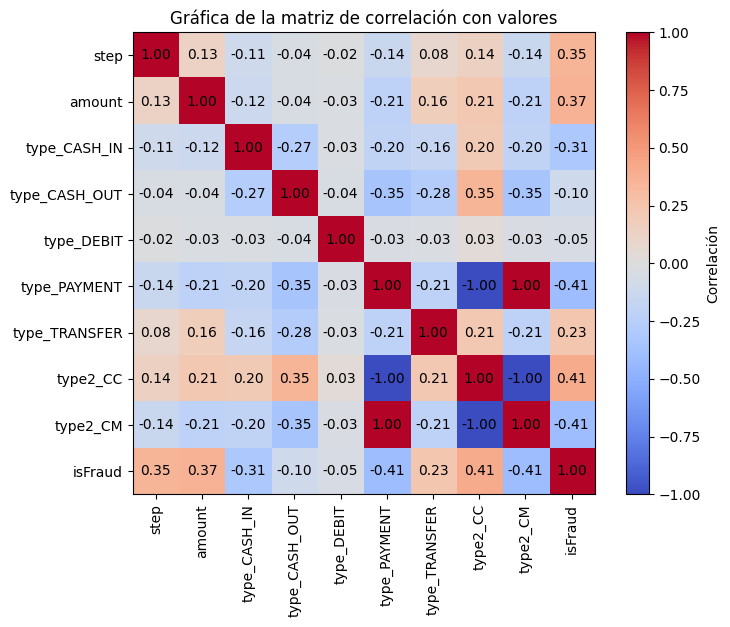

In [93]:
plt.figure(figsize=(8, 6))
plt.imshow(matriz_correlacion, cmap='coolwarm', interpolation='nearest')
plt.xticks(np.arange(len(matriz_correlacion.columns)), matriz_correlacion.columns, rotation=90)
plt.yticks(np.arange(len(matriz_correlacion.columns)), matriz_correlacion.columns)
plt.colorbar(label='Correlación')
plt.title('Gráfica de la matriz de correlación con valores')
for i in range(len(matriz_correlacion.columns)):
    for j in range(len(matriz_correlacion.columns)):
        plt.text(j, i, f'{matriz_correlacion.iloc[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

Se aplica un Standar Sacaler a la columna amount

In [94]:
# Seleccionar la etiqueta a normalizar
etiqueta_a_normalizar = 'amount'

# Inicializar StandardScaler
scaler = StandardScaler()

# Ajustar el escalador solo a la etiqueta
scaler.fit(df_balanceado[[etiqueta_a_normalizar]])

# Transformar la etiqueta
df_balanceado[etiqueta_a_normalizar] = scaler.transform(df_balanceado[[etiqueta_a_normalizar]])

# Ver el DataFrame resultante
df_balanceado.head()

,step,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,isFraud
0,1,-0.426756,0,0,0,0,1,1,0,1
1,1,-0.426756,0,1,0,0,0,1,0,1
2,1,-0.424740,0,0,0,0,1,1,0,1
3,1,-0.424740,0,1,0,0,0,1,0,1
4,1,-0.411442,0,0,0,0,1,1,0,1


Se guarda el dataset procesado


In [ ]:
df_balanceado = pd.read_csv('balanced_data.csv')

# Machine Learning
### Regresión logistica

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [ ]:
# Se dividen los datos en conjuntos de entrenamiento y prueba
X = df_balanceado.drop(columns='isFraud')
y = df_balanceado['isFraud']

# Se dividen los datos en conjunto de prueba y entrenamiento
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Se crea y entrena el modelo
model = LogisticRegression(max_iter=200)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Se calcula la presición del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy del modelo:", accuracy)
print("Precisión del modelo:", precision)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

### Arboles de decisión

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Se crea el modelo y se entrena
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# Predicciones
y_pred = model.predict(x_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy del modelo:", accuracy)
print("Precisión del modelo:", precision)


Accuracy del modelo: 0.9780127182337326
Precisión del modelo: 0.9665936664929202


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Se inicializa y entrena el modelo
model = RandomForestClassifier(max_depth=30, n_estimators=12, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy del modelo:", accuracy)
print("Precisión del modelo:", precision)

Accuracy del modelo: 0.962946906082649
Precisión del modelo: 0.9683137117598144


Se guarda el dataset final 